<span style="font-width:bold; font-size: 3rem; color:#333;">- Part 01: Feature Backfill</span>


## 🗒️ This notebook is divided into the following sections:
1. Fetch historical data
2. Connect to the Hopsworks feature store
3. Create feature groups and insert them to the feature store



### <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import requests
import pandas as pd
import hopsworks
import warnings
import datetime
from pathlib import Path
warnings.filterwarnings("ignore")

---

## <span style='color:#ff5f27'> 🌍 Download the Historical Air Quality Firtt </span>

https://aqicn.org/historical#!city:sweden/stockholm-hornsgatan-108-gata

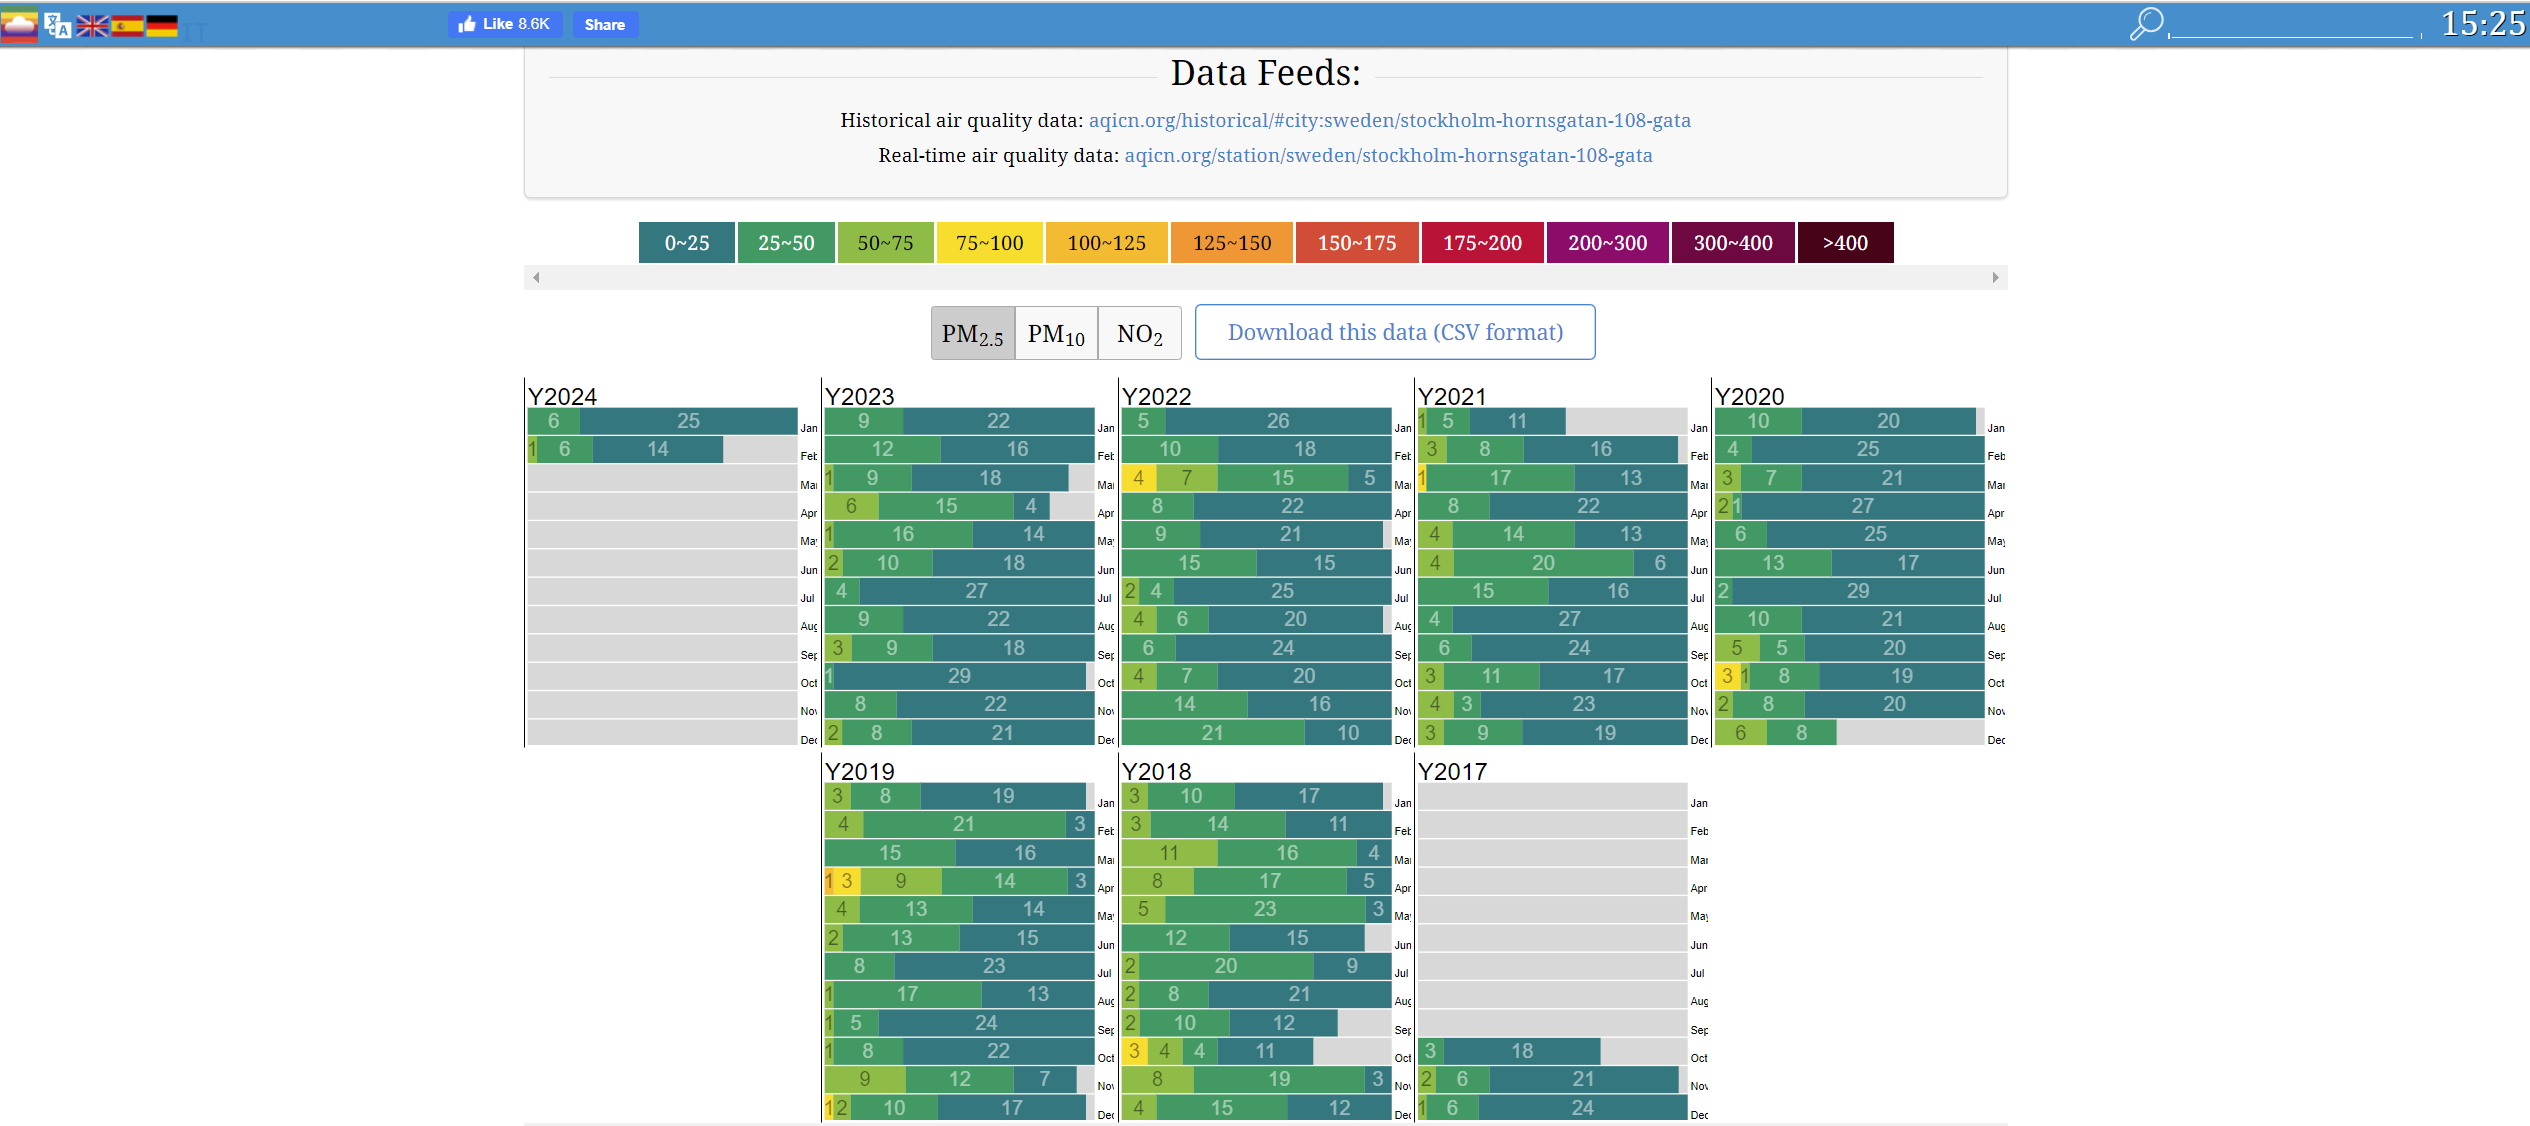


In [2]:
# My URL for my sensor is:
# https://aqicn.org/historical#!city:sweden/stockholm-hornsgatan-108-gata
# city == sweden
# stree == stockholm-hornsgatan-108-gata

# Change the city name below to the nearest city for weather data
city="stockholm"
# Change the country to the first part of the filename for the CSV file you downloaded for your sensor
country="sweden"
# Change the street to the second part of the filename for the CSV file you downloaded for your sensor
street="stockholm-hornsgatan-108-gata"
csv_file="../../data/stockholm-hornsgatan 108 gata-air-quality.csv"

today = datetime.date.today()

In [3]:
df = pd.read_csv(csv_file,  parse_dates=['date'], skipinitialspace=True)
df.isna()

,date,pm25,pm10,no2
0,False,False,False,False
1,False,False,False,False
2,False,False,True,True
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
2301,False,True,True,False
2302,False,True,True,False
2303,False,True,True,False
2304,False,True,True,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2306 non-null   datetime64[ns]
 1   pm25    2269 non-null   float64       
 2   pm10    2269 non-null   float64       
 3   no2     2280 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 72.2 KB


In [5]:
from functions import *

df2 = df[['date', 'pm25']]
df2['country']=country
df2['city']=city
df2['street']=street

latitude, longitude = get_city_coordinates(city)

In [6]:
df2['pm25'] = df2['pm25'].astype('float32')
df2

,date,pm25,country,city,street
0,2024-03-01,46.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1,2024-03-02,59.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2,2024-03-03,48.0,sweden,stockholm,stockholm-hornsgatan-108-gata
3,2024-02-01,22.0,sweden,stockholm,stockholm-hornsgatan-108-gata
4,2024-02-02,22.0,sweden,stockholm,stockholm-hornsgatan-108-gata
...,...,...,...,...,...
2301,2017-10-24,NaN,sweden,stockholm,stockholm-hornsgatan-108-gata
2302,2017-10-25,NaN,sweden,stockholm,stockholm-hornsgatan-108-gata
2303,2017-10-26,NaN,sweden,stockholm,stockholm-hornsgatan-108-gata
2304,2017-10-27,NaN,sweden,stockholm,stockholm-hornsgatan-108-gata


In [7]:
df2.dropna(inplace=True)
df2

,date,pm25,country,city,street
0,2024-03-01,46.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1,2024-03-02,59.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2,2024-03-03,48.0,sweden,stockholm,stockholm-hornsgatan-108-gata
3,2024-02-01,22.0,sweden,stockholm,stockholm-hornsgatan-108-gata
4,2024-02-02,22.0,sweden,stockholm,stockholm-hornsgatan-108-gata
...,...,...,...,...,...
2264,2017-12-26,16.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2265,2017-12-27,10.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2266,2017-12-28,55.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2267,2017-12-29,42.0,sweden,stockholm,stockholm-hornsgatan-108-gata


In [8]:
earliest_aq_date = pd.Series.min(df2['date'])

In [9]:
earliest_aq_date = earliest_aq_date.strftime('%Y-%m-%d')
earliest_aq_date

'2017-10-04'

In [10]:
df_air_quality=df2
df_air_quality.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2269 entries, 0 to 2268
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2269 non-null   datetime64[ns]
 1   pm25     2269 non-null   float32       
 2   country  2269 non-null   object        
 3   city     2269 non-null   object        
 4   street   2269 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 97.5+ KB


### <span style="color:#ff5f27;">🛠 Feature Engineering</span>

In [11]:
# Print the shape (number of rows and columns) of the df_air_quality DataFrame
df_air_quality.shape

(2269, 5)

In [12]:
# Retrieve and display the column names of the df_air_quality DataFrame
df_air_quality.columns

Index(['date', 'pm25', 'country', 'city', 'street'], dtype='object')

---

## <span style='color:#ff5f27'> 🌦 Loading Weather Data from [Open Meteo](https://open-meteo.com/en/docs)

## Instructions for weather
https://open-meteo.com/en/docs/historical-weather-api#hourly=&daily=temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant

In [13]:
weather_df = get_historical_weather(city, earliest_aq_date, str(today))

Coordinates 59.29701232910156°N 18.163265228271484°E
Elevation 18.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [14]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2341 entries, 0 to 2340
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         2341 non-null   datetime64[ns]
 1   temperature_2m_mean          2341 non-null   float32       
 2   precipitation_sum            2341 non-null   float32       
 3   wind_speed_10m_max           2341 non-null   float32       
 4   wind_direction_10m_dominant  2341 non-null   float32       
 5   city                         2341 non-null   object        
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 91.4+ KB


In [15]:
import great_expectations as ge
aq_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="aq_expectation_suite"
)

aq_expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"pm25",
            "min_value":-0.1,
            "max_value":999.9,
            "strict_min":True
        }
    )
)

{"kwargs": {"column": "pm25", "min_value": -0.1, "max_value": 999.9, "strict_min": true}, "expectation_type": "expect_column_min_to_be_between", "meta": {}}

In [16]:
import great_expectations as ge
weather_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="weather_expectation_suite"
)

def expect_greater_than_zero(col):
    weather_expectation_suite.add_expectation(
        ge.core.ExpectationConfiguration(
            expectation_type="expect_column_min_to_be_between",
            kwargs={
                "column":col,
                "min_value":-0.1,
                "max_value":1000.0,
                "strict_min":True
            }
        )
    )
expect_greater_than_zero("precipitation_sum")
expect_greater_than_zero("wind_speed_10m_max")

---

---

### <span style="color:#ff5f27;"> 🔮 Connecting to Hopsworks Feature Store </span>

In [17]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works/p/5240
Connected. Call `.close()` to terminate connection gracefully.


In [18]:
df_air_quality.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2269 entries, 0 to 2268
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2269 non-null   datetime64[ns]
 1   pm25     2269 non-null   float32       
 2   country  2269 non-null   object        
 3   city     2269 non-null   object        
 4   street   2269 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 97.5+ KB


## <span style="color:#ff5f27;">🪄 Creating Feature Groups</span>

### <span style='color:#ff5f27'> 🌫 Air Quality Data

In [19]:
# Get or create feature group
air_quality_fg = fs.get_or_create_feature_group(
    name='air_quality',
    description='Air Quality characteristics of each day',
    version=1,
    primary_key=['country','street','date'],
    event_time="date",
    expectation_suite=aq_expectation_suite
)    

In [20]:
# Insert data
air_quality_fg.insert(df_air_quality)

Feature Group created successfully, explore it at 
https://snurran.hops.works/p/5240/fs/5188/fg/7232
2024-03-03 10:30:16,226 INFO: 	1 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://snurran.hops.works/p/5240/fs/5188/fg/7232


Uploading Dataframe: 0.00% |          | Rows 0/2269 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://snurran.hops.works/p/5240/jobs/named/air_quality_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f65dceda8f0>,
 {
   "evaluation_parameters": {},
   "meta": {
     "great_expectations_version": "0.15.12",
     "expectation_suite_name": "aq_expectation_suite",
     "run_id": {
       "run_time": "2024-03-03T10:30:16.226540+00:00",
       "run_name": null
     },
     "batch_kwargs": {
       "ge_batch_id": "06a32abe-d949-11ee-9543-2ab97fc7e5f0"
     },
     "batch_markers": {},
     "batch_parameters": {},
     "validation_time": "20240303T103016.226488Z",
     "expectation_suite_meta": {
       "great_expectations_version": "0.15.12"
     }
   },
   "results": [
     {
       "result": {
         "observed_value": 4.0,
         "element_count": 2269,
         "missing_count": null,
         "missing_percent": null
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "validationTime": "2024

In [21]:
air_quality_fg.update_feature_description("date", "Date of measurement of air quality")
air_quality_fg.update_feature_description("country", "Country where the air quality was measured (sometimes a city in acqcn.org)")
air_quality_fg.update_feature_description("city", "City where the air quality was measured")
air_quality_fg.update_feature_description("street", "Street in the city where the air quality was measured")
air_quality_fg.update_feature_description("pm25", "Particles less than 2.5 micrometers in diameter (fine particles) pose health risk")

### <span style='color:#ff5f27'> 🌦 Weather Data

In [22]:
# Get or create feature group 
weather_fg = fs.get_or_create_feature_group(
    name='weather',
    description='Weather characteristics of each day',
    version=1,
    primary_key=['city','date'],
    event_time="date",
    expectation_suite=weather_expectation_suite
) 

In [23]:
# Insert data
weather_fg.insert(weather_df)

Feature Group created successfully, explore it at 
https://snurran.hops.works/p/5240/fs/5188/fg/7233
2024-03-03 10:30:24,672 INFO: 	2 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://snurran.hops.works/p/5240/fs/5188/fg/7233


Uploading Dataframe: 0.00% |          | Rows 0/2341 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: weather_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://snurran.hops.works/p/5240/jobs/named/weather_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f65dceda710>,
 {
   "evaluation_parameters": {},
   "meta": {
     "great_expectations_version": "0.15.12",
     "expectation_suite_name": "weather_expectation_suite",
     "run_id": {
       "run_time": "2024-03-03T10:30:24.672619+00:00",
       "run_name": null
     },
     "batch_kwargs": {
       "ge_batch_id": "0babe9ce-d949-11ee-9543-2ab97fc7e5f0"
     },
     "batch_markers": {},
     "batch_parameters": {},
     "validation_time": "20240303T103024.672570Z",
     "expectation_suite_meta": {
       "great_expectations_version": "0.15.12"
     }
   },
   "results": [
     {
       "result": {
         "observed_value": 3.41525936126709,
         "element_count": 2341,
         "missing_count": null,
         "missing_percent": null
       },
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       },
       "meta": {
         "ingestionResult": "INGESTED",
         "vali

In [24]:
weather_fg.update_feature_description("date", "Date of measurement of weather")
weather_fg.update_feature_description("city", "City where weather is measured/forecast for")
weather_fg.update_feature_description("temperature_2m_mean", "Temperature in Celsius")
weather_fg.update_feature_description("precipitation_sum", "Precipitation (rain/snow) in mm")
weather_fg.update_feature_description("wind_speed_10m_max", "Wind speed at 10m abouve ground")
weather_fg.update_feature_description("wind_direction_10m_dominant", "Dominant Wind direction over the dayd")

## <span style="color:#ff5f27;">⏭️ **Next:** Part 02: Feature Pipeline 
 </span> 

In the following notebook you will parse data and insert it into Feature Groups.

## <span style="color:#ff5f27;">⏭️ **Exercises:** 
 </span> 
    
    * Add a rolling window of 3 days and 5 days for 'pm25'
        df.set_index("date").rolling(3).mean().head()
